### 랭그래프를 사용해야 되는 이유
- 랭체인
    - 프롬프트 + 모델 + 아웃풋파서
    - 체인 + rag -> rag 시스템
    - 체인 + 툴 -> 에이전트
    - 툴 : 그냥 파이썬 함수
    - 쉽게 쉽게 가능 -> 비교적 워크플로가 단순할 때, 단방향일 때, 제어를 그렇게 디테일하게 하지 않아도 될 때
- 랭그래프
    - 제어가 디테일하게 해야 할 때
    - 체인   - 체인
            - 체인
            - 체인 다중 체인일 때는 오히려 랭체인으로 코드짜기가 더 어렵다
    - 랭체인 기능을 랭그래프로 못하냐 -> 가능하다
    - 이제부터는 랭그래프로 생각하시면 되겠다
    - 조금더 복잡한 워크플로일 때 -> 작업 흐름도

- 랭그래프 설계
    - 기능의 작업 흐름도 설계
    - 예시
        - 보고서 작성 기능 - 아래의 내용이 노드가
            1. 유저가 프롬프트를 입력
            - 2-1. 웹서치 해야 할까
            - 2-2. Rag 로 데이터 서치
            3. 두 데이터를 합쳐서 -> context로 저장
            4. context 기반으로 보고서 양식으로 출력
            5. 마음에 들경우 -> 6, 마음에 안 들경우 -> 2-1 부터 다시 시작  (conditional_edge)
            6. 파일로 저장해보기
            7. 최종 결과 내용을 출력

In [1]:
# 가장 간단한 선형 그래프 만들기
# 사실 알고보면 랭체인과 별반 다를게 없다

In [2]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
load_dotenv()

True

### 1. State 정의 
- 중앙에다가 형식 정해놓고 저장해놓는 현재의 상태를 나타내는 DB라고 생각

In [5]:
class State(TypedDict):
    message : str

### 2. 노드 함수 정의 
1. 안녕하세요
2. 이름 추가 : ~님
3. 오늘 하루 화이팅입니다.
    이렇게 메시지를 추가하는 노드를 만들어보기

In [ ]:
def node_1(cur_state : State):
    """개발자 만 보는 노드의 기능을 설명하면 됩니다. 나만 보는거"""
    # 우리는 항상 출력을 해서 그래프의 흐름을 체크해야 함
    print("node_1 :메시지 시작")
    print(cur_state)
    return {"message" : "안녕하세요"}

def node_2(cur_state : State):
    """두번째 노드: 메시지 추가 기능"""

    # 우리는 항상 출력을 해서 그래프의 흐름을 체크해야 함
    print("node_2 :메시지 시작")
    print(cur_state)
    cur_message = cur_state['message']
    return {"message" : cur_message + "윤택한님" }

def node_3(cur_state : State):
    """세번째 노드: 인사말 추가 기능"""

    # 우리는 항상 출력을 해서 그래프의 흐름을 체크해야 함
    print("node_3 :메시지 시작")
    print(cur_state)
    cur_message = cur_state['message']
    return {"message" : cur_message + "오늘 하루 화이팅입니다" }

### 3. 그래프 만들기

In [ ]:
# 그래프 초기화
workflow = StateGraph(State)

workflow.add_node("node_1", node_1)
workflow.add_node("node_2", node_2)
workflow.add_node("node_3", node_3)

# 엣지 -> 순서 -> 작업 연결
workflow.add_edge("node_1", "node_2")
workflow.add_edge("node_2", "node_3")

# 시작점 연결
workflow.add_edge(START, "node_1")
# workflow.set_entry_point("node_1")

# 마지막 연결
workflow.add_edge("node_3", END)
# workflow.set_finish_point("node_3")

workflow.__dict__

{'nodes': {'node_1': StateNodeSpec(runnable=node_1(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.State'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
  'node_2': StateNodeSpec(runnable=node_2(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.State'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
  'node_3': StateNodeSpec(runnable=node_3(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.State'>, retry_policy=None, cache_policy=None, ends=(), defer=False)},
 'edges': {('__start__', 'node_1'),
  ('node_1', 'node_2'),
  ('node_2', 'node_3'),
  ('node_3', '__end__')},
 'branches': defaultdict(dict, {}),
 'schemas': {__main__.State: {'message': <langgraph.channels.last_value.LastValue at 0x26fa51d0340>}},
 'channels': {'message': <langgraph.channels.last_value.LastValue at 0x26fa51d034

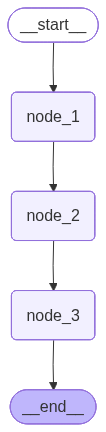

In [ ]:
graph = workflow.compile()
graph

### 4. 그래프 실행

In [ ]:
init_message = {"message" : ""}
result = graph.invoke(init_message)
print(result)

node_1: 메시지 시작
{'message': ''}
node_2: 메시지 시작
{'message': '안녕하세요'}
node_3: 메시지 시작
{'message': '안녕하세요차요준님'}
{'message': '안녕하세요차요준님오늘 하루 화이팅입니다.'}


In [ ]:
# 연습문제 1: 3개 노드 만들어서 "원티드에서 AI 수업 듣고 있어요. 참 즐거워요. 프로젝트 즐거워요" 출력하는 노드만들기
# 연습문제 2: 숫자를 계속 1 ~ 10까지 더하고, 11부터는 짝수만 더하기 20까지, 최종 결과 출력, 중간 중간 결과 확인해보는 노드 만들기

# 연습문제 2 워크플로
# 1. 1~ 10까지 더하기
# 2. 중간결과 확인하는 노드만들기
# 3. 12, 14, 16, 18, 20 더하기

In [33]:
# 연습문제 2 워크플로
# 상태 정의
class State(TypedDict):
    numbers : int
    test : str
    message : str

# 노드 정의
def sum1(sum_current: State):
    """1~ 10까지 더하기"""
    cur_num = sum_current["numbers"]
    print("현재 값은 : ", cur_num)
    return {"numbers" : cur_num + sum(range(1, 11))}

def display(cur_state: State):
    """중간 결과 출력해보기"""
    print("첫번째 노드 결과 ", cur_state['numbers'])
    print("**의 결과가 궁금해서 출력해보기 ", {**cur_state})
    """
    **cur_state 는
    ("numbers", 55)
    ("test",10)
    ("message", "테스트중")

    """

    test_number = cur_state["test"]
    test_message = cur_state["message"]
    # return {**cur_state}

    return {"numbers" : 125,
            "test" : test_number,
            "message" :test_message,
            "numbers" : 100
            }

# 노드 등록, 엣지 등록

workflow = StateGraph(State)
workflow.add_node("node_1", sum1)
workflow.add_node("node_2", display)

# 엣지 등록
workflow.add_edge("node_1", "node_2")
workflow.set_entry_point("node_1")
workflow.set_finish_point("node_1")

app = workflow.compile()
app

In [34]:
result = app.invoke({'numbers': 0})
print(result)

In [35]:
workflow = StateGraph(State)

workflow.add_node("node_1", node_1)
workflow.add_node("node_2", node_2)
workflow.add_node("node_3", node_3)
workflow.add_node("node_4", node_4)

workflow.add_edge("node_1", "node_2")
workflow.add_edge("node_2", "node_3")
workflow.add_edge("node_3", "node_4")
workflow.add_edge("node_4", END)
workflow.add_edge(START, "node_1")

workflow.__dict__

{'nodes': {'node_1': StateNodeSpec(runnable=node_1(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.State'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
  'node_2': StateNodeSpec(runnable=node_2(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.State'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
  'node_3': StateNodeSpec(runnable=node_3(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.State'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
  'node_4': StateNodeSpec(runnable=node_4(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.State'>, retry_policy=None, cache_policy=None, ends=(), defer=False)},
 'edges': {('__start__', 'node_1'),
  ('node_1', 'node_2'),
  ('node_2', 'node_3'),
  ('node_3', 'node_4'),
  

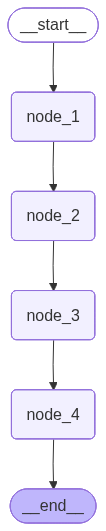

In [36]:
graph = workflow.compile()
graph

In [37]:
init_message = {"message": ""}
result = graph.invoke(init_message)
print(result)

node_1: 메시지 시작
{'message': ''}
node_2: 메시지 시작
{'message': '원티드에서 AI 수업 듣고 있어요.'}
node_3: 메시지 시작
{'message': '원티드에서 AI 수업 듣고 있어요.참 즐거워요.'}
node_4: 메시지 시작
{'message': '원티드에서 AI 수업 듣고 있어요.참 즐거워요.프로젝트 즐거워요.'}
{'message': '원티드에서 AI 수업 듣고 있어요.참 즐거워요.프로젝트 즐거워요.출력하는 노드 만들기.'}
